# Time series plotting around reservoirs

## To-dos
- [ ] sum precip from mm/hr to mm
- [x] spatial aggregation of GRACE subset to single time series
- [x] spatial aggregation of CYGNSS subset to single time series
- [x] spatial aggregation of IMERG subset to single time series
- [ ] convert time series functions & spatial functions to new class

In [1]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'

In [2]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions
import area_subsets
import area_calcs

In [3]:
# fw_DA = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()
res_shp = load_data.load_GRanD()
precip_DA = load_data.load_IMERG()

In [35]:
def single_timeseries_IMERG_CYGNSS_GRACE(dam_name,subset_method='polygon',**plot_params):
    """
    Description
    -----------
    Hard-coded time series slicing for IMERG and CYGNSS to start two months after the intersecting_timeframes() start date
    
    Inputs
    ------
    dam_name: name of a dam in the GRanD reservoir dataset
    subset_method : str
        default : 'polygon'
        accepted : 'polygon' , 'point'
        allows for updated polygon or older point-based subsetting
    **plot_params : dict
        dictionary of plot formatting options and labels
            Keys used: None, all passed to `three_part_timeseries`

    Outputs
    -------
    precip , fw , cmwe : Pandas Series
        Series used for plotting
        Respectively, precipitation, fractional water, TWS
    """
    global precip_DA , grace_dict, res_shp
    
    if 'polygon' in subset_method.lower():
        subset_gpd = area_subsets.check_for_multiple_dams(dam_name,res_shp)
        precip_multi , precip_full = area_subsets.precip_shape_subset(
                             subset_gpd,
                             precip_DA,
                             buffer_val=0.25,
                             crs_code=4326)
        
        subset_bbox = subset_gpd.geometry.buffer(0).bounds
        fw_DA = load_data.load_CYGNSS_001_all_months(subset_bbox.values[0])
        fw_multi , fw_full = area_subsets.cygnss_shape_subset(
                             subset_gpd,
                             fw_DA,
                             buffer_val=0.25,
                             crs_code=4326)
        
        cmwe_multi , mascon_ts , cmwe_full = area_subsets.grace_shape_subset(
                                subset_gpd,
                                grace_dict,
                                buffer_val=0)        
    elif 'point' in subset_method.lower():
        coords_i = area_subsets.reservoir_name_to_point(res_oi,res_shp)
        
        precip_full = area_subsets.precip_point_subset(coords_i,precip_DA)
        fw_full = area_subsets.cygnss_point_subset(coords_i,fw_DA)
        cmwe_full , mascon_ts = area_subsets.grace_point_subset(coords_i,grace_dict)

    precip , fw , cmwe = time_series_calcs.intersecting_timeframes(precip_full,fw_full,cmwe_full,buffer=0)
    precip = precip[2:]
    fw = fw[2:]
    
    plot_params['data_labels'] = ['IMERG','CYGNSS','GRACE']
    plot_params['x_label'] = 'Time'
    plot_params['y_labels'] = ['Precip (mm/hr)', 'Fraction of surface water coverage', 'TWS water equivalence (cm)']
    plot_params['line_fmt'] = ['c-','b-','k-']
    plot_params['figsize'] = (12,6)

    plotting_functions.three_part_timeseries([precip , fw , cmwe],**plot_params)
    
    return precip , fw , cmwe

/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)
/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)
/global/home/users/ann_scheliga/.conda/envs/rioxarray_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


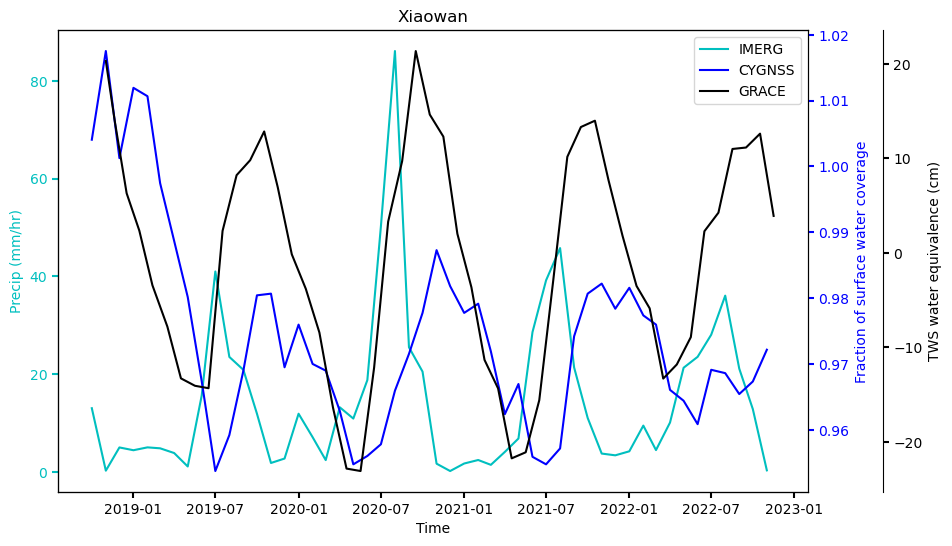

In [36]:
res_oi = 'Xiaowan'
plot_params = {
    'title' : res_oi
}
precip_series , fw_series , cmwe_series = single_timeseries_IMERG_CYGNSS_GRACE(
    res_oi,
    **plot_params,
    subset_method='polygon')

## Trying out new time series metrics

In [33]:
precip_series

2018-10-01    13.051001
2018-11-01     0.272000
2018-12-01     5.023000
2019-01-01     4.453000
2019-02-01     5.038000
2019-03-01     4.846000
2019-04-01     3.879000
2019-05-01     1.130000
2019-06-01    15.683001
2019-07-01    41.012002
2019-08-01    23.537001
2019-09-01    20.897001
2019-10-01    11.927001
2019-11-01     1.847000
2019-12-01     2.752000
2020-01-01    11.919001
2020-02-01     7.130000
2020-03-01     2.436000
2020-04-01    13.239001
2020-05-01    10.930000
2020-06-01    18.799001
2020-07-01    50.271002
2020-08-01    86.107004
2020-09-01    25.510001
2020-10-01    20.532001
2020-11-01     1.703000
2020-12-01     0.199000
2021-01-01     1.735000
2021-02-01     2.453000
2021-03-01     1.465000
2021-04-01     4.116000
2021-05-01     6.851000
2021-06-01    28.605001
2021-07-01    39.194002
2021-08-01    45.800002
2021-09-01    21.391001
2021-10-01    11.054000
2021-11-01     3.770000
2021-12-01     3.411000
2022-01-01     4.232000
2022-02-01     9.489000
2022-03-01     4

## Older time series metrics from TSM class objects

In [6]:
def series_to_TSM_object(input_series,*TSM_args,**TSM_kwargs):
    series_obj = input_series.astype(float)
    series_obj.index = list(map(time_series_calcs.toYearFraction,series_obj.index))
    TSM_obj = time_series_calcs.TimeSeriesMetrics(series_obj,*TSM_args,**TSM_kwargs)
    return TSM_obj

In [7]:
precip_ts = series_to_TSM_object(precip_series,'IMERG')
fw_ts = series_to_TSM_object(fw_series,'CYGNSS')
cmwe_ts = series_to_TSM_object(cmwe_series,'GRACE')

In [8]:
# precip_ts.coef_determination(fw_ts)
# precip_ts.coef_determination(cmwe_ts)
fw_ts.coef_determination(precip_ts)
# fw_ts.coef_determination(cmwe_ts)
cmwe_ts.coef_determination(precip_ts)
cmwe_ts.coef_determination(fw_ts);

---coef of determination----
Between CYGNSS and IMERG
-311.36407868544813
---coef of determination----
Between GRACE and IMERG
-1.0679947480030076
---coef of determination----
Between GRACE and CYGNSS
0.03590561931225067


## Spatial aggregation work of polygon subset to single time series

In [12]:
subset_gpd

,GRAND_ID,RES_NAME,DAM_NAME,ALT_NAME,RIVER,ALT_RIVER,MAIN_BASIN,SUB_BASIN,NEAR_CITY,ALT_CITY,...,MULTI_DAMS,TIMELINE,COMMENTS,URL,QUALITY,EDITOR,LONG_DD,LAT_DD,POLY_SRC,geometry
7213,7284,NaN,Xiaowan,NaN,Lacang,NaN,Mekong,NaN,Fengqing,NaN,...,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Xiaowan_Dam,2: Good,McGill-PB,100.093825,24.706595,JRC,"POLYGON ((99.34543 25.41472, 99.34644 25.41277..."


In [13]:
# GRACE = success.
subset_gpd = area_subsets.check_for_multiple_dams('Xiaowan',res_shp,idx=0)
test_cmwe , test_mascon , test_cmwe_agg = area_subsets.grace_shape_subset(subset_gpd,
                                grace_dict,
                                buffer_val=0)
test_cmwe_agg = test_cmwe.mul(test_mascon['area_km2'],axis='index').sum(axis=0)/(test_mascon['area_km2'].sum())
    # weighted average
test_polygon_agg = test_mascon.geometry.unary_union

In [14]:
# CYGNSS = success.
subset_gpd = area_subsets.check_for_multiple_dams('Xiaowan',res_shp,idx=0)
test_fw = area_subsets.xr_shape_subset(subset_gpd,
                             fw_DA,
                             buffer_val=0.25,
                             crs_code=4326)
test_fw_agg = test_fw.mean(dim=['lat','lon'])

/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)


In [17]:
# IMERG
subset_gpd = area_subsets.check_for_multiple_dams('Xiaowan',res_shp,idx=0)
test_precip = area_subsets.xr_shape_subset(subset_gpd,
                             precip_DA,
                             buffer_val=0.25,
                             crs_code=4326)

/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)


## Scratchwork

In [18]:
coords_i = area_subsets.reservoir_name_to_point('Indirasagar',res_shp)

precip_xr = precip_DA.sel(lat=coords_i[0],lon=coords_i[1],method='nearest')
dates_precip = np.array(list(map(lambda x: pd.Timestamp('1980-01-06') + pd.DateOffset(seconds=x),precip_xr['time'].values)))
    # Time = seconds since 1980 Jan 06 (UTC), per original HDF5 IMERG file units
precip_ts = pd.Series(data=precip_xr,index=dates_precip)

In [19]:
def IMERG_timestamp_to_pdTimestamp(input_xrcoord):
    dates_precip = np.array(list(map(lambda x: pd.Timestamp('1980-01-06') + pd.DateOffset(seconds=x),input_xrcoord.values)))
    return dates_precip

In [20]:
precip_multi , precip_full = area_subsets.precip_shape_subset(
                        subset_gpd,
                        precip_DA,
                        buffer_val=0.25,
                        crs_code=4326)

/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)


In [24]:
test_bbox.values[0]

array([-47.27891547, -20.28875   , -47.06381592, -20.10622425])

Dam name estreito is redundant. 2 entires found.


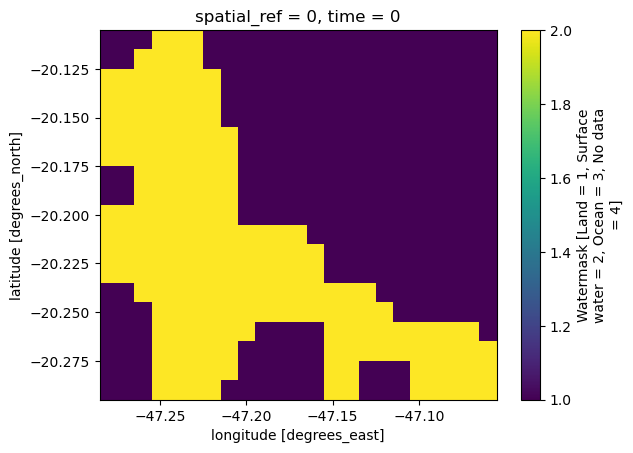

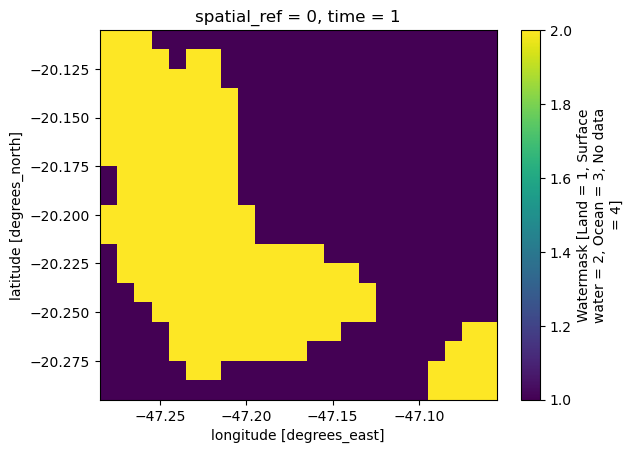

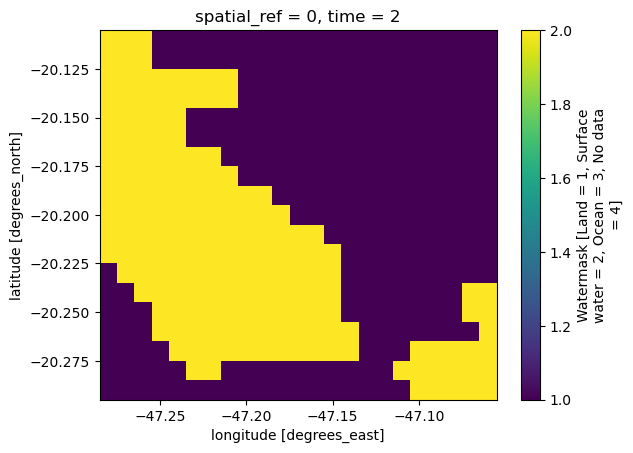

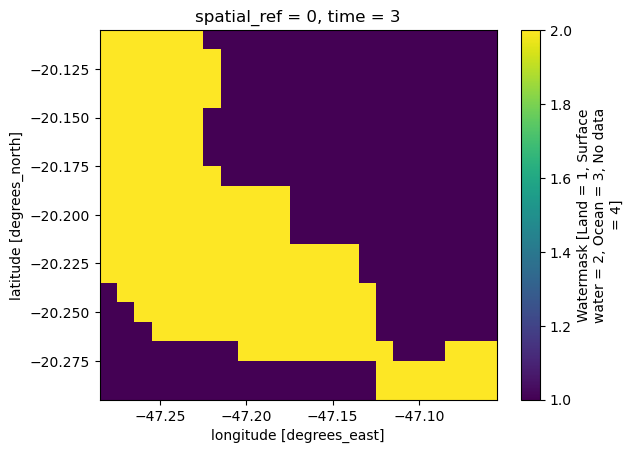

In [26]:
subset_gpd = area_subsets.check_for_multiple_dams('estreito',res_shp,idx=0)
test_bbox = subset_gpd.geometry.buffer(0).bounds

test_cygnss = load_data.load_CYGNSS_001_all_months(test_bbox.values[0])
for i in np.arange(4):
    plt.figure()
    test_cygnss[i,:,:].plot()

In [27]:
area_subsets.reservoir_name_to_point('Xiaowan',res_shp) , area_subsets.reservoir_name_to_point('Nuozhadu',res_shp)

((24.706595, 100.093825), (22.640879, 100.429623))

In [28]:
res_shp[res_shp['DAM_NAME'] =='Nuozhadu'].squeeze().head(15)

GRAND_ID          7232
RES_NAME           NaN
DAM_NAME      Nuozhadu
ALT_NAME           NaN
RIVER          Lancang
ALT_RIVER       Mekong
MAIN_BASIN      Mekong
SUB_BASIN          NaN
NEAR_CITY        Pu'er
ALT_CITY           NaN
ADMIN_UNIT      Yunnan
SEC_ADMIN          NaN
COUNTRY          China
SEC_CNTRY          NaN
YEAR              2014
Name: 7162, dtype: object

In [29]:
res_shp[res_shp['ADMIN_UNIT'] == 'Yunnan']

,GRAND_ID,RES_NAME,DAM_NAME,ALT_NAME,RIVER,ALT_RIVER,MAIN_BASIN,SUB_BASIN,NEAR_CITY,ALT_CITY,...,MULTI_DAMS,TIMELINE,COMMENTS,URL,QUALITY,EDITOR,LONG_DD,LAT_DD,POLY_SRC,geometry
5094,5098,NaN,Shuanghua,NaN,Trib. Jinsha Jiang,NaN,Chang Jiang,Jinsha Jiang,Luquan,NaN,...,NaN,NaN,NaN,NaN,3: Fair,McGill-BL,102.461897,26.016159,SWBD,"POLYGON ((102.44209 26.03209, 102.44341 26.031..."
5095,5099,NaN,Haishao,NaN,Trib. Jinsha Jiang,NaN,Chang Jiang,Jinsha Jiang,Binchuan,Bingchuan,...,NaN,NaN,NaN,NaN,2: Good,McGill-BL,100.648745,25.693068,SWBD,"POLYGON ((100.65333 25.69315, 100.65486 25.692..."
5100,5104,NaN,Xincun,NaN,Menguo He,NaN,NaN,NaN,Wudin,NaN,...,NaN,NaN,NaN,NaN,2: Good,McGill-BL,102.172917,25.501605,SWBD,"POLYGON ((102.17487 25.50237, 102.17621 25.500..."
5102,5106,NaN,Dumu,NaN,Trib. Nanpan Jiang,NaN,Zhu Jiang,NaN,Mohong,Qujing,...,NaN,NaN,Updated year Dec 2018,NaN,3: Fair,McGill-PB,104.102814,25.298266,GLWD,"POLYGON ((104.14391 25.33762, 104.14258 25.336..."
5114,5118,NaN,Qiezishan Reservoir,NaN,Supa,NaN,Salween,NaN,Baoshan,NaN,...,NaN,NaN,Updated year Dec 2018,NaN,3: Fair,McGill-PB,98.809509,24.506716,SWBD,"POLYGON ((98.80032 24.53966, 98.80154 24.53874..."
5115,5119,NaN,Dongfeng,NaN,Qu Jiang,Trib. Jinsha Jiang,Chang Jiang,Jinsha Jiang,Yuxi,NaN,...,NaN,NaN,NaN,NaN,3: Fair,McGill-BL,102.578208,24.372969,SWBD,"POLYGON ((102.58070 24.37542, 102.58235 24.374..."
6967,7025,NaN,Ahai,NaN,Jinsha,NaN,Yangtzee,NaN,Ninglang,NaN,...,NaN,NaN,Some records indicate a much smaller reservoir...,https://en.wikipedia.org/wiki/Ahai_Dam,4: Poor,McGill-PB,100.506077,27.352000,JRC,"POLYGON ((100.50518 27.34948, 100.50388 27.350..."
6979,7037,NaN,Dachaoshan,NaN,Lacang,NaN,Mekong,NaN,Jingdong,NaN,...,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Dachaoshan_Dam,2: Good,McGill-PB,100.368647,24.027054,JRC,"POLYGON ((100.39575 24.09250, 100.39563 24.090..."
7022,7085,NaN,Gelantan,NaN,Lixian,NaN,Red,NaN,Jiangcheng,NaN,...,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Gelantan_Dam,2: Good,McGill-PB,102.056621,22.703891,JRC modified,"POLYGON ((101.99637 22.78862, 101.99663 22.788..."
7024,7087,NaN,Gongguoqiao,NaN,Lacang,NaN,Mekong,NaN,Yunlong,NaN,...,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Gongguoqiao_Dam,2: Good,McGill-PB,99.335411,25.585622,JRC,"POLYGON ((99.36487 25.63063, 99.36689 25.63195..."


In [30]:
res_shp.loc[:,['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)

,DAM_NAME,COUNTRY,MAIN_USE,YEAR,CAP_MCM
4488,Owen Falls,Uganda,Hydroelectricity,1954,204800.0
4052,Kariba,Zimbabwe,Hydroelectricity,1959,185000.0
5051,Bratsk,Russia,Hydroelectricity,1964,169000.0
4474,High Aswan Dam,Egypt,Irrigation,1970,162000.0
3663,Akosombo Main Dam,Ghana,Hydroelectricity,1965,148000.0
...,...,...,...,...,...
6780,Rangipo,New Zealand,Hydroelectricity,1980,0.2
6801,Lower Manorburn,New Zealand,Irrigation,1933,0.2
4268,Rietport,South Africa,Irrigation,1955,0.1
6787,Lower Karori,New Zealand,Water supply,1872,0.1


In [31]:
res_shp.loc[res_shp['MAIN_BASIN'] == 'Mekong',['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)

,DAM_NAME,COUNTRY,MAIN_USE,YEAR,CAP_MCM
7162,Nuozhadu,China,Hydroelectricity,2014,23703.0
7213,Xiaowan,China,Hydroelectricity,2012,15043.0
5132,Nam Ngum,Laos,Hydroelectricity,1972,7030.0
6946,Nam Ngum 2,Laos,Hydroelectricity,2011,4230.0
6948,Xe Kaman 1,Laos,Hydroelectricity,2015,3210.0
6944,Nam Theun 2,Laos,Hydroelectricity,2010,3210.0
5145,Ubol Ratana,Thailand,Irrigation,1966,2263.0
5792,Sirindhorn,Thailand,Hydroelectricity,1971,1966.0
7232,Lower Sesan II,Cambodia,Hydroelectricity,2017,1790.0
5146,Lam Pao,Thailand,Irrigation,1969,1430.0
